# mount google colab & import utility functions

In [1]:
import pathlib
import os

#mount google drive
from google.colab import drive
DRIVE_PATH = pathlib.Path("/content/drive")
drive.mount(str(DRIVE_PATH)) #mount google drive at /content/drive in session

Mounted at /content/drive


In [2]:
PROJ = "MyDrive/github/dogclassifier"
PROJECT_PATH = DRIVE_PATH.joinpath(PROJ)
UTILS_PATH = PROJECT_PATH.joinpath('utils')
CKPT_PATH = PROJECT_PATH.joinpath('checkpoints')

#change to UTILS_PATH to import utils
os.chdir(UTILS_PATH) #change working dir to PROJECT_PATH
import utils

In [3]:
#plotting
import matplotlib.pyplot as plt

#tensorflow imports
import tensorflow as tf

# get data

In [4]:
import tensorflow_datasets as tfds

(train_set, test_set), ds_info = tfds.load(name='stanford_dogs',
                                           split=['train', 'test'],
                                           with_info=True,
                                           as_supervised=True,
                                           shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0ZO739/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0ZO739/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
class_names = ds_info.features['label'].names


shape of image: (1879, 1388, 3)


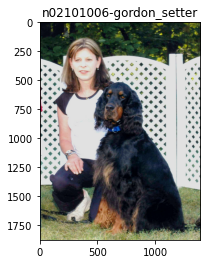

In [6]:
train_sample = train_set.take(1)
for image, label in train_sample:
    print(f"shape of image: {image.shape}")
    plt.imshow(image)
    plt.title(f"{class_names[label.numpy()]}")

# preprocess data

## pre-processing function

In [7]:
def preprocess_image(image, label, image_shape=224):
    """
    Pre-process image: resize image tensor to (image_shape, image_shape), cast to tf.float32
    """
    image = tf.image.resize(image, size=(image_shape, image_shape))
    image = tf.cast(image, dtype=tf.float32)
    return image, label

image, label = preprocess_image(image, label)
print(f"shape of image after preprocessing {image.shape}")

shape of image after preprocessing (224, 224, 3)


## pre-process data & batch data

In [8]:
#batch training data
train_set = train_set.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#batch test data
test_set = test_set.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(32).prefetch(tf.data.AUTOTUNE)

# resnet50v2 model

## create model architecture

In [9]:
#resnet50v2 base model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
resnet_base_model = ResNet50V2(include_top=False,
                               weights='imagenet',
                               pooling='avg' #apply global average pooling to output of last conv block
                               )
resnet_base_model.trainable = False #freeze base model layers

#keras
from tensorflow.keras import layers

#create model
input_ = layers.Input(shape=(224, 224, 3), name='input_layer')
print(f"output of Input layer {input_.shape}")

x = layers.Lambda(resnet_preprocess)(input_)
print(f"output of Lambda layer {x.shape}")

x = resnet_base_model(x, training=False)
print(f"output of resnet_base_model layer {x.shape}")

output_ = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
print(f"output of Dense layer {output_.shape}")

resnet50v2_feature_model = tf.keras.Model(inputs=[input_], outputs=[output_])
resnet50v2_feature_model.summary()




94683136/94668760 [==============================] - 2s 0us/step
output of Input layer (None, 224, 224, 3)
output of Lambda layer (None, 224, 224, 3)
output of resnet_base_model layer (None, 2048)
output of Dense layer (None, 120)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 output_layer (Dense)        (None, 120)               245880    
                                                                 
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
__________

In [ ]:
# tf.keras.utils.plot_model(resnet50v2_feature_model, show_shapes=True)

In [10]:
resnet50v2_feature_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## model paths setup & callbacks


In [11]:
expt = 'resnet50v2_feature'
checkpoint_path = CKPT_PATH.joinpath(expt, 'checkpoint.ckpt')
model_path = CKPT_PATH.joinpath(expt, 'resnet50v2_feature.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   monitor='val_accuracy', 
                                                   save_best_only=True,
                                                   save_weights_only=True)

## fit model

In [13]:
history_resnet50v2_feature = resnet50v2_feature_model.fit(train_set,
                                                          epochs=5,
                                                          steps_per_epoch=len(train_set),
                                                          validation_steps=int(0.15*len(test_set)),
                                                          validation_data=test_set,
                                                          callbacks=[checkpoint_cb, ],
                                                          verbose=1
                                                          )

Epoch 1/5
375/375 [==============================] - 38s 69ms/step - loss: 1.4823 - accuracy: 0.6092 - val_loss: 1.0076 - val_accuracy: 0.7164
Epoch 2/5
375/375 [==============================] - 27s 69ms/step - loss: 0.5510 - accuracy: 0.8283 - val_loss: 1.0182 - val_accuracy: 0.7172
Epoch 3/5
375/375 [==============================] - 27s 68ms/step - loss: 0.3368 - accuracy: 0.8968 - val_loss: 1.0295 - val_accuracy: 0.7305
Epoch 4/5
375/375 [==============================] - 26s 67ms/step - loss: 0.2115 - accuracy: 0.9436 - val_loss: 1.0535 - val_accuracy: 0.7289
Epoch 5/5
375/375 [==============================] - 26s 67ms/step - loss: 0.1420 - accuracy: 0.9677 - val_loss: 1.1098 - val_accuracy: 0.7203


## evaluate model

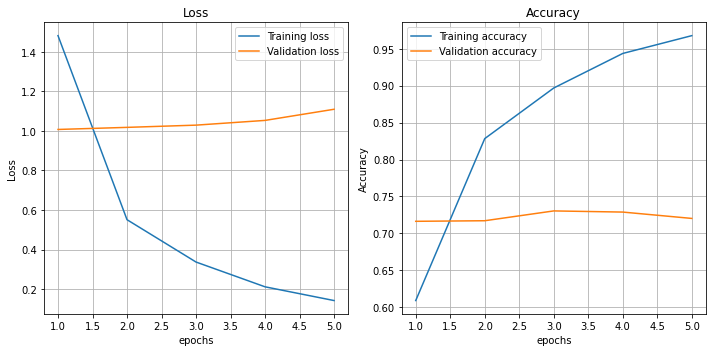

In [14]:
utils.plot_loss_curves(history_resnet50v2_feature)

In [15]:
resnet50v2_feature_model.save(model_path)

# EfficientNetB0 model

## create model architecture

In [16]:
#base model
effnetb0_base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                               weights='imagenet',
                               pooling='avg' #apply global average pooling to output of last conv block
                               )
effnetb0_base_model.trainable = False #freeze base model layers

#keras
from tensorflow.keras import layers

#create model
input_ = layers.Input(shape=(224, 224, 3), name='input_layer')
print(f"output of Input layer {input_.shape}")

x = effnetb0_base_model(input_, training=False)
print(f"output of resnet_base_model layer {x.shape}")

output_ = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
print(f"output of Dense layer {output_.shape}")

effnetb0_feature_model = tf.keras.Model(inputs=[input_], outputs=[output_])
effnetb0_feature_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
output of Input layer (None, 224, 224, 3)
output of resnet_base_model layer (None, 1280)
output of Dense layer (None, 120)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 120)               153720    
                                                                 
Total params: 4,203,291
Trainable params: 153,720
Non-trainable params: 4,049,571
_________________________________________________________________


In [17]:
effnetb0_feature_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## callbacks

In [22]:
expt = 'effnetb0_feature'
checkpoint_path = CKPT_PATH.joinpath(expt, 'checkpoint.ckpt')
model_path = CKPT_PATH.joinpath(expt, 'effnetb0_feature.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   monitor='val_accuracy', 
                                                   save_best_only=True,
                                                   save_weights_only=True)

## fit

In [23]:
history_effnetb0_feature = effnetb0_feature_model.fit(train_set,
                                                      epochs=5,
                                                      steps_per_epoch=len(train_set),
                                                      validation_data=test_set,
                                                      validation_steps=int(0.15*len(test_set)),
                                                      callbacks=[checkpoint_cb, ],
                                                      verbose=1)

Epoch 1/5
375/375 [==============================] - 27s 67ms/step - loss: 0.1867 - accuracy: 0.9615 - val_loss: 0.5568 - val_accuracy: 0.8266
Epoch 2/5
375/375 [==============================] - 27s 67ms/step - loss: 0.1528 - accuracy: 0.9724 - val_loss: 0.5628 - val_accuracy: 0.8242
Epoch 3/5
375/375 [==============================] - 26s 67ms/step - loss: 0.1268 - accuracy: 0.9789 - val_loss: 0.5647 - val_accuracy: 0.8242
Epoch 4/5
375/375 [==============================] - 26s 67ms/step - loss: 0.1060 - accuracy: 0.9834 - val_loss: 0.5741 - val_accuracy: 0.8195
Epoch 5/5
375/375 [==============================] - 27s 67ms/step - loss: 0.0892 - accuracy: 0.9882 - val_loss: 0.5738 - val_accuracy: 0.8234


## evaluate model

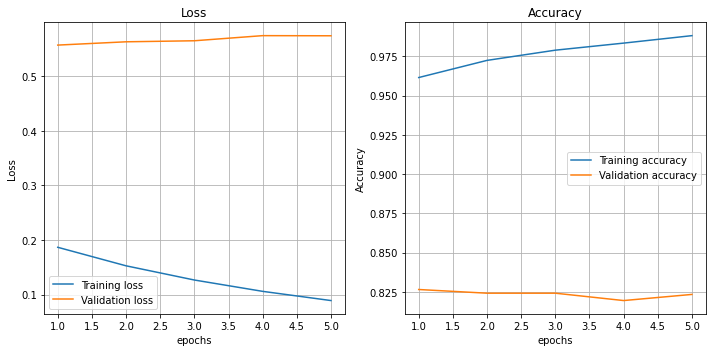

In [24]:
utils.plot_loss_curves(history_effnetb0_feature)

In [25]:
effnetb0_feature_model.save(model_path)

# Effnetb0 with data augmentation

## model architecture

In [21]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
                        preprocessing.RandomFlip("horizontal"),
                        preprocessing.RandomRotation(0.2),
                        preprocessing.RandomZoom(0.2),
                        preprocessing.RandomHeight(0.2),
                        preprocessing.RandomWidth(0.2),
                        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [22]:
#base model
effnetb0_base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                           weights='imagenet',
                                                           pooling='avg')
effnetb0_base_model.trainable = False

#build model
input_ = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(input_)
x = effnetb0_base_model(x, training=False)
output_ = keras.layers.Dense(units=len(class_names), activation='softmax', name='dense_output')(x)

effnetb0_aug_feature_model = tf.keras.Model(inputs=[input_,], outputs=[output_])
effnetb0_aug_feature_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_output (Dense)        (None, 120)               153720    
                                                                 
Total params: 4,203,291
Trainable params: 153,720
Non-trainable params: 4,049,571
_________________________________________________________________


In [23]:
effnetb0_aug_feature_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                   optimizer=tf.keras.optimizers.Adam(),
                                   metrics=['accuracy'])

## callbacks

In [24]:
expt = 'effnetb0_aug_feature'
checkpoint_path = CKPT_PATH.joinpath(expt, 'checkpoint.ckpt')
model_path = CKPT_PATH.joinpath(expt, 'effnetb0_feature.h5')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   monitor='val_accuracy',
                                                   save_best_only=True,
                                                   save_weights_only=True)

## fit model

In [25]:
history_effnetb0_aug_feature = effnetb0_aug_feature_model.fit(train_set,
                                                                epochs=5,
                                                                steps_per_epoch=len(train_set),
                                                                validation_data=test_set,
                                                                validation_steps=int(0.15*len(test_set)),
                                                                callbacks=[checkpoint_cb, ],
                                                                verbose=1)

Epoch 1/5
375/375 [==============================] - 37s 82ms/step - loss: 2.3117 - accuracy: 0.4817 - val_loss: 0.9124 - val_accuracy: 0.7789
Epoch 2/5
375/375 [==============================] - 30s 76ms/step - loss: 1.2656 - accuracy: 0.6579 - val_loss: 0.7143 - val_accuracy: 0.7953
Epoch 3/5
375/375 [==============================] - 29s 75ms/step - loss: 1.0837 - accuracy: 0.6984 - val_loss: 0.6521 - val_accuracy: 0.8039
Epoch 4/5
375/375 [==============================] - 29s 73ms/step - loss: 0.9621 - accuracy: 0.7294 - val_loss: 0.6330 - val_accuracy: 0.8039
Epoch 5/5
375/375 [==============================] - 29s 73ms/step - loss: 0.8849 - accuracy: 0.7463 - val_loss: 0.6059 - val_accuracy: 0.8102


## evaluate model

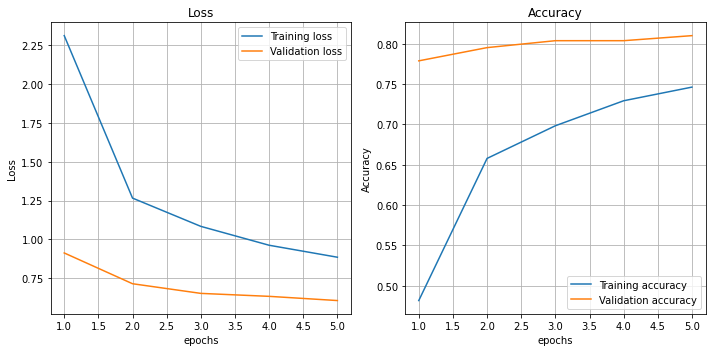

In [26]:
utils.plot_loss_curves(history_effnetb0_aug_feature)

In [27]:
effnetb0_aug_feature_model.save(model_path)